In [1]:

import logging
import pickle
import dill
import numpy as np
import matplotlib.pyplot as plt

#from src.emulator import Emulator
from src.emulator_BAND import EmulatorBAND

In [2]:
def loadEmulator(emulatorPathList):
        emuList = []
        for i, emuPath in enumerate(emulatorPathList):
            with open(emuPath, 'rb') as f:
                emu_i = dill.load(f)
                emuList.append(emu_i)
        logging.info("Number of Emulators: {}".format(len(emuList)))
        return emuList

In [3]:
#The EMULATOR and the DATA file have to FIT together
folder = "/home/niklas/Desktop/lustre/good_bayes/inference/actual/emulator_full/no_log/no_pca/PCGP/"
emuPathList = [folder+"data:allenergies:allsystems:base-star-eta:3.0:nostarptcut:tau_nolog_nopca_PCGP"
            ]

emu_list = loadEmulator(emuPathList)

[INFO][480296221] Number of Emulators: 1


In [ ]:


file_path = '/home/niklas/Desktop/lustre/good_bayes/inference/actual/latent_train_full/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut:tau.pkl'

with open(file_path,'rb') as file:
    loaded_data = pickle.load(file)

In [6]:
PARAMETER_NAMES = [
r'$\tau_{IC,scale}\;({\rm fm})$',
r'$a_{h,\eta}$',
r'$a_{l,\eta}$',
r'$\epsilon_{\rm sw}\;({\rm GeV/fm^3})$',
r'$(\eta/s)_{\rm min}$',
r'$a_{\mu_B}$',
r'$b_{\mu_B}$',
r'$R_{\perp}$',
r'$R_{\eta}$',
r'$T_{\eta, \rm 0}\;({\rm GeV})$',
r'$(\zeta/s)_{\rm 0}$',
r'$(\epsilon)_{\zeta,\rm 0 }\;({\rm GeV/fm^3})$',
r'$\sigma_{\zeta, \rm -}\;({\rm GeV})$',
r'$\sigma_{\zeta, \rm +}\;({\rm GeV})$',
r'$\sigma_{\rm AB, scale}$',
]

x = np.arange(len(PARAMETER_NAMES))

In [ ]:
def extract_info_from_filename(filename):
    # Remove the path and extension
    parts = filename.split('_')
    
    # Extract energy, centrality, and observable
    energy = parts[1]
    centrality = parts[2]
    observable = '_'.join(parts[3:])


    
    return energy, centrality, observable

import re

def convert_to_notation(filename):
    # Remove 'exp_', '../latent_pickled/', and '.pkl'
    filename = re.sub(r'(exp_|\.pkl|../latent_pickled/)', '', filename)
    filename = re.sub(r'star_v(.*)_pT', r'starv\1pt', filename)
    filename = re.sub(r'star_v', 'starv', filename)
    filename = re.sub(r'phenix_pT_v', 'phenixptv', filename)
    filename = re.sub(r'stareta_spectra', 'etas', filename)
    filename = re.sub(r'eta_spectra', 'etas', filename)
    filename = re.sub(r'y_spectra', 'ys', filename)
    filename = re.sub(r'pT_spectra', 'pTs', filename)
    filename = re.sub(r'phobos_v2_spectra', 'v2eta', filename)
    # Mapping for observables
    observables = {
        'etas': r'$\frac{dN}{d\eta}$',
        'ys': r'$\frac{dN}{dy}$',
        'pTs': r'$\frac{dN}{d(p_T)}$',
        'dNdy': r'$\left.\frac{dN}{dy}\right|_{y=0}$',
        'meanpT': r'$\langle p_T \rangle |_{y=0}$',
        'starv2': r'$\left.v_{2/3}\right.\{2\}$',
        'starv3': r'',
        'phenixptv2': r'$v_2(p_T)$',
        'phenixptv3': r'$v_3(p_T)$',
        'starv2pt': r'$v_2(p_T)$',
        'starv3pt': r'$v_3(p_T)$',
        'v2eta': r'$v_2(\eta)$'
    }
    particles= {
        'kminus': r'K^-',
        'kplus': r'K^+',
        'p': 'p',
        'pbar': r'\bar{p}',
        'piminus': r'\pi^-',
        'piplus': r'\pi^+'
    }   
    
    # Identify the particle and the observable
    #print(filename)
    parts = filename.split('_')
    #print(parts)
    particle = ''
    observable = ''
    integrated = False
    for part in parts:
        if part in observables:
            observable = observables[part]
        elif part in particles:
            particle = particles[part]
        elif part == 'integrated':
            integrated = True
    # Add particle notation for y_spectra
    #print(parts)
    if integrated and  parts[1]=="tau":
        return "wrong"
    if integrated and ("star" not in parts[1]) and ((parts[2] == 'kplus' and parts[1]  == 'dNdy') or (parts[2]  == 'kminus' and parts[1] == 'meanpT')):
        pass
    elif integrated and particle != '':
        observable = ''
    elif ('ys' in filename or 'pTs' in filename or integrated) and not 'star' in filename:
        observable = observable[:-1] + f'({particle})$'

   
    #print(observable)
    #print("------")
    # Return the formatted string
    return observable

from collections import defaultdict
import numpy as np

# Extract relevant information and store in a list of tuples
data_list = []
for i, name in enumerate(loaded_data[0]["name"]):
    energy, centrality, observable = extract_info_from_filename(name)
    start = loaded_data[0]["lim"][i]
    end = loaded_data[0]["lim"][i + 1]
    if (convert_to_notation(observable)=="wrong"):
        continue
    data_list.append((energy, centrality, observable, start, end, i))

# Define a custom order for the energy
energy_order = {'7.7': 0, '19.6': 1, '200': 2}

# Sort the list of tuples by the custom energy order and then by centrality
data_list.sort(key=lambda x: (energy_order[x[0]], x[1]))

# Recalculate ytickPos based on the sorted order
yticksLabel = []
ytickPos = []
yInfo = []
current_pos = 0
for energy, centrality, observable, start, end, original_index in data_list:
    space = end - start
    mid_pos = current_pos + space / 2
    if (convert_to_notation(observable)=="wrong"):
    #     print("YALLA")
         continue
    yticksLabel.append(convert_to_notation(observable))
    ytickPos.append(mid_pos)
    yInfo.append((energy, centrality, space / 2))
    current_pos += space

# Calculate the response matrix
num_obs = len(loaded_data[1]['obs'][0])
num_param = len(loaded_data[1]['parameter'])
response_matrix = np.zeros((num_obs, num_param))
num_points=1
for a in range(num_points):
    
    #center of the posterior
    X = np.array([1.3405,11.7024,-12.5323,0.5029,0.2185,3.2318,0.0373,0.6321,1.6955,0.1313,0.0916,25.7295,0.0589,0.0824,0.9769], ndmin=2)
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    X_scaled = (X - X_min) / (X_max - X_min + 1e-8)
    for j in range(num_param):
        X_h_1 = np.copy(X_scaled)
        X_h_2 = np.copy(X_scaled)
        h = 0.1 * X_h_1[0, j]
        if h < 1e-2:
            h = 1e-2  # Set a small epsilon if h is zero
        X_h_1[0, j] = X_h_1[0, j] + h
        X_h_2[0, j] = X_h_2[0, j] - h
        Y_h_1 = []
        Y_h_2 = []
        for emu in emu_list:
            Y_h_1.append(emu.predict(X_h_1, return_cov=False))
            Y_h_2.append(emu.predict(X_h_2, return_cov=False))
        Y_h_1_ = np.concatenate(Y_h_1, axis=1)
        Y_h_2_ = np.concatenate(Y_h_2, axis=1)
        denominator = (Y_h_1_[0, :] + Y_h_2_[0, :])
        small_value_mask = np.abs(denominator) < 1e-8  # Mask small or zero denominators
        
        # Safely calculate the response matrix with masked values
        safe_denominator = np.where(small_value_mask, 1e-8, denominator)  # Avoid division by zero

        response_matrix[:, j] += (Y_h_1_[0, :] - Y_h_2_[0, :]) / (2 * h) * X[0, j] / np.abs(((Y_h_1_[0, :] + Y_h_2_[0, :]) * 2*num_points))

# Apply the same sorting to the response matrix
sorted_response_matrix = np.zeros_like(response_matrix)
current_pos = 0
for energy, centrality, observable, start, end, original_index in data_list:
    if (convert_to_notation(observable)=="wrong"):
 
         continue
    space = end - start

    sorted_response_matrix[current_pos:current_pos + space, :] = response_matrix[start:end, :]
    current_pos += space

response_matrix = sorted_response_matrix

0


[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral


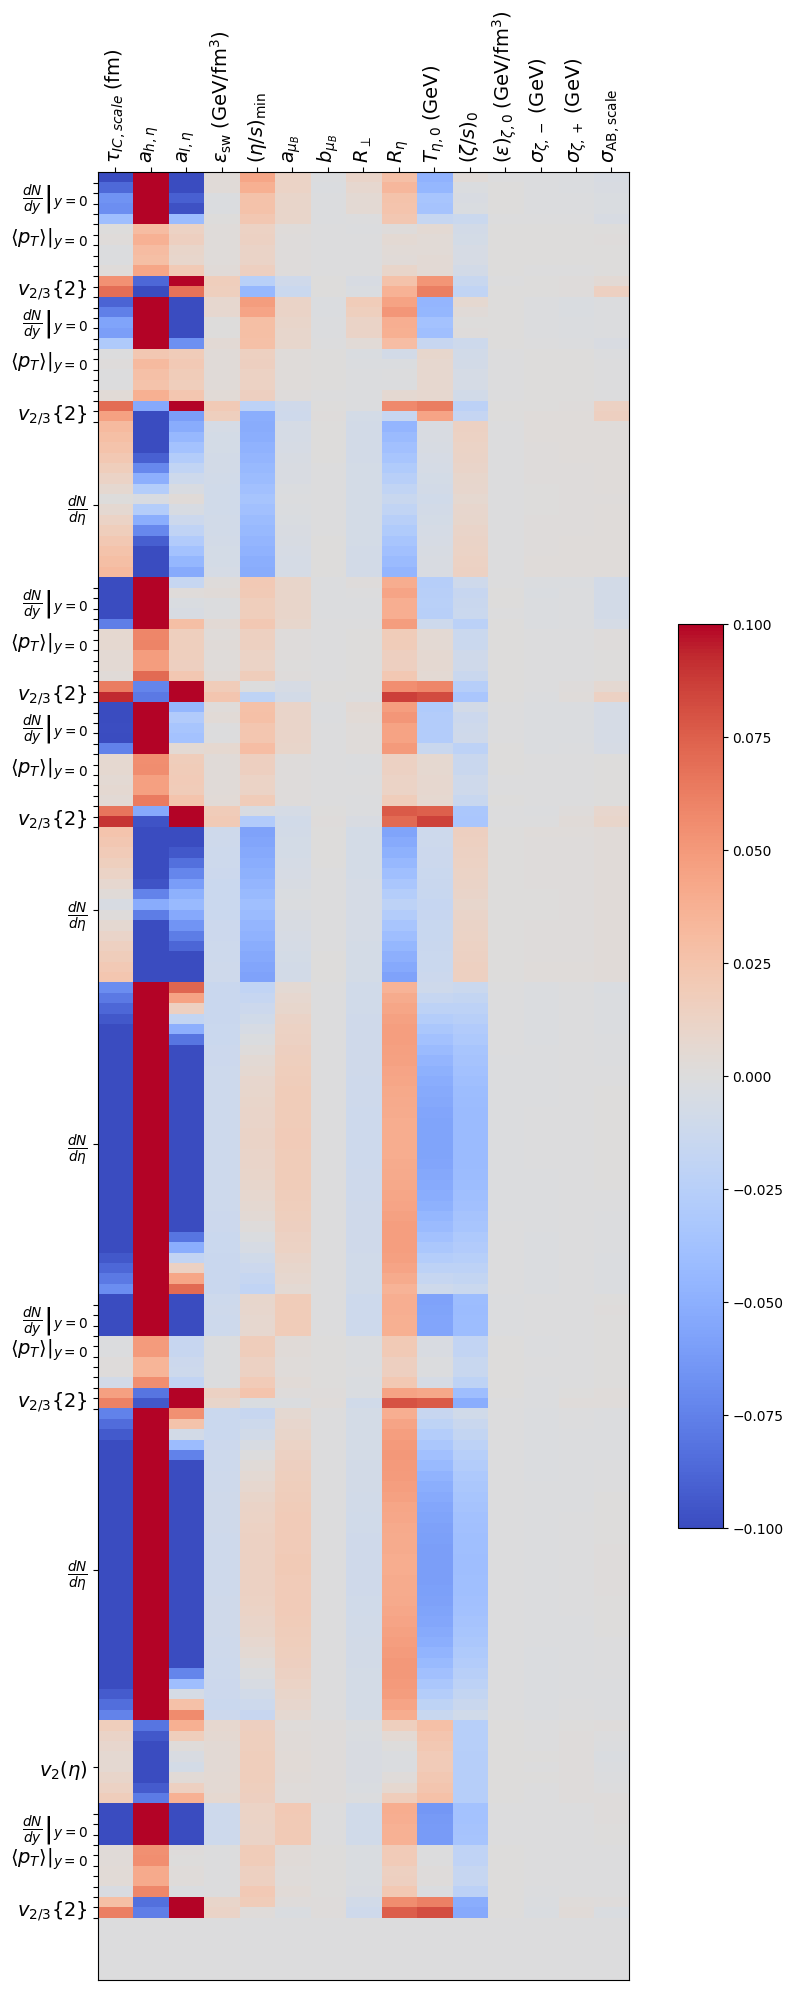

In [ ]:
#UNSPLIT

min_value = np.amin(response_matrix)
max_value = np.amax(response_matrix)
c_value = max(min_value, max_value)

height, width = response_matrix.shape
aspect_ratio = 3.4*((width)/(height))

# Split the response matrix into two parts
half_width = width // 2+5
response_matrix_1, response_matrix_2 = np.hsplit(response_matrix, [half_width])

plt.figure(figsize=(10, 20))
plt.imshow(response_matrix, cmap='coolwarm', vmin=-0.1, vmax=0.1, aspect = aspect_ratio, interpolation = 'nearest')
# Add color bar
plt.colorbar(shrink=0.5)  # Adjust shrink value as needed


ax = plt.gca()
ax.xaxis.tick_top()
ax.set_yticks(ytickPos)
ax.set_yticklabels(yticksLabel, rotation=0)
plt.yticks(fontsize = 14)
plt.xticks(x, PARAMETER_NAMES, fontsize=14, rotation = 90)
plt.tight_layout()
plt.savefig("heatmap_1099.pdf")
plt.show()


[('7.7', '05', 'integrated_dNdy_kminus', 106, 107, 42), ('7.7', '05', 'integrated_dNdy_kplus', 107, 108, 43), ('7.7', '05', 'integrated_dNdy_piminus', 108, 109, 44), ('7.7', '05', 'integrated_dNdy_piplus', 109, 110, 45), ('7.7', '05', 'integrated_dNdy_p', 110, 111, 46), ('7.7', '05', 'integrated_meanpT_kminus', 111, 112, 47), ('7.7', '05', 'integrated_meanpT_kplus', 112, 113, 48), ('7.7', '05', 'integrated_meanpT_piminus', 113, 114, 49), ('7.7', '05', 'integrated_meanpT_piplus', 114, 115, 50), ('7.7', '05', 'integrated_meanpT_p', 115, 116, 51), ('7.7', '05', 'integrated_star_v2', 116, 117, 52), ('7.7', '05', 'integrated_star_v3', 117, 118, 53), ('7.7', '2030', 'integrated_dNdy_kminus', 161, 162, 68), ('7.7', '2030', 'integrated_dNdy_kplus', 162, 163, 69), ('7.7', '2030', 'integrated_dNdy_piminus', 163, 164, 70), ('7.7', '2030', 'integrated_dNdy_piplus', 164, 165, 71), ('7.7', '2030', 'integrated_dNdy_p', 165, 166, 72), ('7.7', '2030', 'integrated_meanpT_kminus', 166, 167, 73), ('7.7', 

/tmp/ipykernel_1496858/4144412313.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral


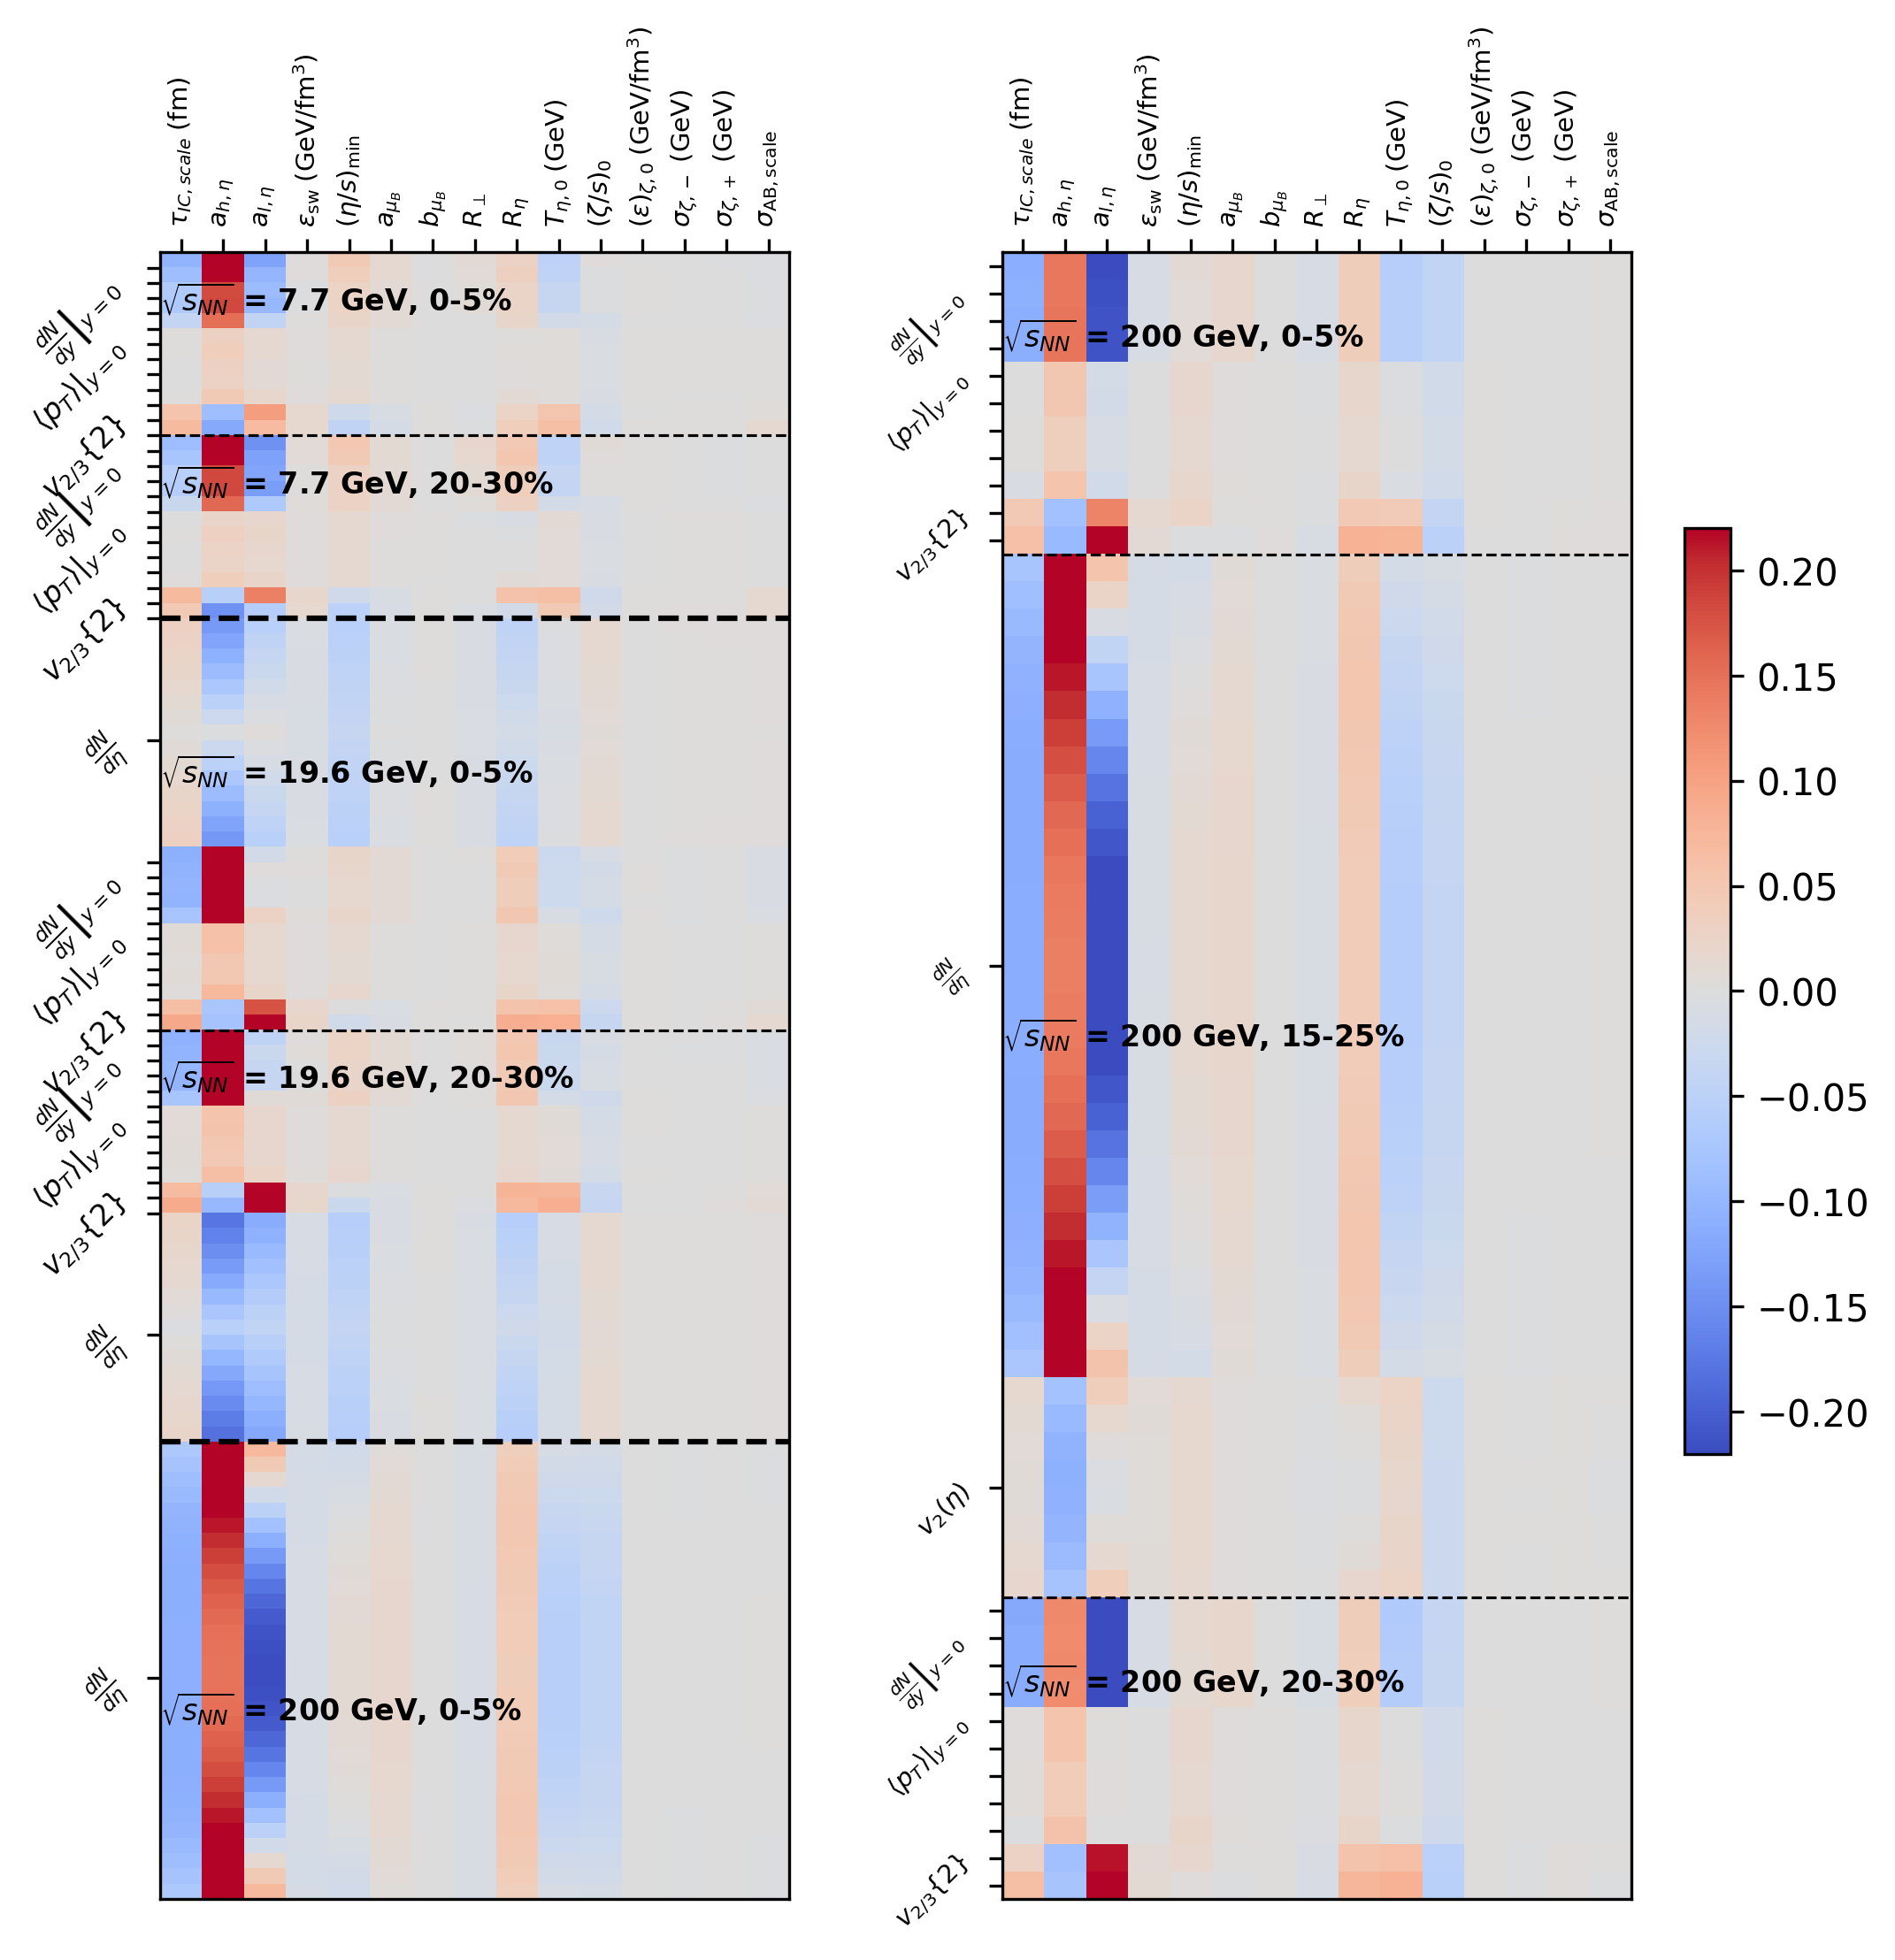

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate cumulative number of rows for each label
cumulative_rows = [0]
for _, _, observable, start, end, _ in data_list:
    if convert_to_notation(observable) == "wrong":
        continue
    cumulative_rows.append(cumulative_rows[-1] + (end - start))

# Determine the index where to split the matrix, by total rows, not labels
half_total_rows = cumulative_rows[-1] // 2

# Find the index in data_list where the total number of rows surpasses half_total_rows
split_index = next(i for i, cum_row in enumerate(cumulative_rows) if cum_row >= half_total_rows)

# Now split the response matrix at this index
response_matrix_1 = response_matrix[:cumulative_rows[split_index], :]
response_matrix_2 = response_matrix[cumulative_rows[split_index]:-6, :]

# Split yticksLabel and ytickPos according to the same split index
yticksLabel_1 = yticksLabel[:split_index]
#print(yticksLabel_1)
ytickPos_1 = ytickPos[:split_index]

yticksLabel_2 = yticksLabel[split_index:]
ytickPos_2 = [pos - ytickPos[split_index] for pos in ytickPos[split_index:]]

# Create two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(7.5,7.5 ), dpi=300)

cent = {"05": "0-5", "2030": "20-30", "1525": "15-25", "3050": "30-50"}

# Define a function to draw borders and labels for each subplot
def draw_borders_and_labels(ax, start_index, end_index, current_y_pos):
    current_energy = None
    current_centrality = None
    is_first_section = True  # Flag to track the first section
    if(start_index!=0):
        current_centrality="2030"
    for index in range(start_index, end_index):
        energy, centrality, observable, start, end, original_index = data_list[index]
        space = end - start

        # Draw thick dashed line for energy borders, except for the first section
        if not is_first_section and (current_energy is None or current_energy != energy):
            ax.axhline(y=current_y_pos-0.5, color='black', linestyle='--', linewidth=1.5)  # Thick line for energy
            # Update the text position slightly below the line
            ax.text(-0.5, current_y_pos + space / 2 + 2, r'$\sqrt{s_{NN}}$ = ' + energy + ' GeV, ' + cent[centrality] + '%', 
                    verticalalignment='center', fontsize=8, color='black', weight='bold')

        # Draw thin dashed line for centrality borders
        if current_centrality != centrality and current_energy == energy:
            ax.axhline(y=current_y_pos-0.5, color='black', linestyle='--', linewidth=0.75)  # Thin line for centrality
            # Update the text position slightly below the line
            ax.text(-0.5, current_y_pos + space / 2 + 2, r'$\sqrt{s_{NN}}$ = ' + energy + ' GeV, ' + cent[centrality] + '%', 
                    verticalalignment='center', fontsize=8, color='black', weight='bold')
        
        if current_centrality is None: 
            #ax.axhline(y=current_y_pos, color='black', linestyle='-.', linewidth=1)
            ax.text(-0.5, current_y_pos + space / 2 + 2, r'$\sqrt{s_{NN}}$ = ' + energy + ' GeV, ' + cent[centrality] + '%', 
                    verticalalignment='center', fontsize=8, color='black', weight='bold')
        if current_energy is None and start_index!=0:
            ax.text(-0.5, current_y_pos + space / 2 + 2, r'$\sqrt{s_{NN}}$ = ' + energy + ' GeV, ' + cent[centrality] + '%', 
                    verticalalignment='center', fontsize=8, color='black', weight='bold')

        # Update the current energy and centrality
        current_energy = energy
        current_centrality = centrality
        is_first_section = False  # Mark that the first section has been processed

        # Update current y position after processing the current observable
        current_y_pos += space

    return current_y_pos

# Plot the first half of the response matrix (left observables)
aspect_ratio_1 = response_matrix_1.shape[1] / response_matrix_1.shape[0]
im1 = axs[0].imshow(response_matrix_1, cmap='coolwarm', vmin=-0.22, vmax=0.22, aspect=aspect_ratio_1*2.618, interpolation='nearest')
axs[0].xaxis.tick_top()
axs[0].set_yticks(ytickPos_1)
axs[0].set_yticklabels(yticksLabel_1, rotation=45, fontsize=8)  # Increased fontsize

# Draw borders and labels for the first subplot
current_y_pos_1 = 0  # Starting y position for the first subplot
draw_borders_and_labels(axs[0], 0, len(data_list[:split_index]), current_y_pos_1)
print(data_list[:split_index])
#Plot the second half of the response matrix (right observables)
aspect_ratio_2 = response_matrix_2.shape[1] / response_matrix_2.shape[0]
im2 = axs[1].imshow(response_matrix_2, cmap='coolwarm', vmin=-0.22, vmax=0.22, aspect=aspect_ratio_2*2.618, interpolation='nearest')
axs[1].xaxis.tick_top()
axs[1].set_yticks(ytickPos_2)
axs[1].set_yticklabels(yticksLabel_2, rotation=45, fontsize=7)  # Increased fontsize

# Draw borders and labels for the second subplot
current_y_pos_2 = 0  # Starting y position for the second subplot
#print("blbl")
draw_borders_and_labels(axs[1], len(data_list[:split_index]), len(data_list), current_y_pos_2)

# Add colorbar
cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.03, pad=0.1, shrink=0.8)

# Set x-ticks for both subplots
x = np.arange(len(PARAMETER_NAMES))
axs[0].set_xticks(x)
axs[0].set_xticklabels(PARAMETER_NAMES, fontsize=7, rotation=90)  # Increased fontsize
axs[1].set_xticks(x)
axs[1].set_xticklabels(PARAMETER_NAMES, fontsize=7, rotation=90)  # Increased fontsize

plt.tight_layout()
plt.subplots_adjust(right=0.85, wspace=0.2)

# Save the figure with a transparent background
plt.savefig("heatmap_sensitivity.png", transparent=True,dpi=300)
plt.show()
with open("response_matrix.csv", "w") as csv_file:
    csv_file.write("# This file contains the entire response matrix used for the heatmap.\n")
    csv_file.write("# The first row is: row_label,column1,column2, etc.\n\n")

    # Write column labels
    csv_file.write("#,")
    csv_file.write(",".join(PARAMETER_NAMES))
    csv_file.write("\n")

    # Write each row of data, prefixed by its label
    for i, row_label in enumerate(yticksLabel):
        row_data = response_matrix[i, :]
        csv_file.write(f"{row_label},{','.join(str(val) for val in row_data)}\n")